# Sprint 1: Camera Calibration Module

**Project:** Road Defect Detection Pipeline (PROSIT 1)  
**Team:** Naa Lamle Boye, Thomas Kojo Quarshie, Chelsea Owusu, Elijah Boateng  
**Date:** February 2026

## Purpose

This notebook calibrates the smartphone camera to determine its **intrinsic parameters**
(camera matrix K and distortion coefficients). Camera calibration is essential because
a camera lens bends light, causing straight lines to appear curved (barrel distortion).
Without correcting this, all downstream area measurements will be inaccurate.

**Deliverable:** `camera_calib.npz` file containing calibration parameters.

## Step 1: Import Libraries

In [1]:
import numpy as np
import cv2
import os
import time
%matplotlib inline
import matplotlib.pyplot as plt

print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

OpenCV version: 4.13.0
NumPy version: 2.4.2


## Step 2: Configuration

The checkerboard has 9 columns x 6 rows of squares, giving **8 x 5 = 40 internal corners**.
We process video frames at half resolution (1080p) for faster corner detection.

In [2]:
# Checkerboard internal corners: (columns-1, rows-1)
CHECKERBOARD = (8, 5)

# Sub-pixel refinement: stop after 30 iterations or 0.001 px accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 3D object points (Z=0 because checkerboard is flat)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Storage for correspondences
objpoints = []
imgpoints = []

# Calibration videos
video_files = [
    'checkerboard/IMG_1059.MOV',
    'checkerboard/IMG_1060.MOV',
    'checkerboard/IMG_1061.MOV',
    'checkerboard/IMG_1062.MOV'
]

SAMPLE_RATE = 5
print(f"Checkerboard: {CHECKERBOARD[0]}x{CHECKERBOARD[1]} = {CHECKERBOARD[0]*CHECKERBOARD[1]} corners")
print(f"Videos: {len(video_files)}, Sample rate: every {SAMPLE_RATE}th frame")

Checkerboard: 8x5 = 40 corners
Videos: 4, Sample rate: every 5th frame


## Step 3: Extract Checkerboard Corners from Videos

For each sampled frame: convert to grayscale, detect corners, refine to sub-pixel accuracy,
and store the 3D-to-2D correspondences. Frames are processed at half resolution for speed.

In [3]:
start_time = time.time()
image_size = None
sample_frames = {}

for video_path in video_files:
    cap = cv2.VideoCapture(video_path)
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    found = 0
    idx = 0
    saved = False

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if idx % SAMPLE_RATE == 0:
            small = cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2))
            gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
            if image_size is None:
                image_size = gray.shape[::-1]

            flags = (cv2.CALIB_CB_ADAPTIVE_THRESH +
                     cv2.CALIB_CB_NORMALIZE_IMAGE +
                     cv2.CALIB_CB_FAST_CHECK)
            ret_c, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, flags)

            if ret_c:
                corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
                objpoints.append(objp)
                imgpoints.append(corners2)
                found += 1
                if not saved:
                    vis = small.copy()
                    cv2.drawChessboardCorners(vis, CHECKERBOARD, corners2, True)
                    sample_frames[video_path] = vis
                    saved = True
        idx += 1
    cap.release()
    print(f"{os.path.basename(video_path)}: {found} valid frames (of {nframes} total)")

elapsed = time.time() - start_time
print(f"\nTotal valid frames: {len(objpoints)}")
print(f"Calibration image size: {image_size}")
print(f"Processing time: {elapsed:.1f}s")

IMG_1059.MOV: 6 valid frames (of 150 total)


IMG_1060.MOV: 26 valid frames (of 614 total)


IMG_1061.MOV: 0 valid frames (of 192 total)


IMG_1062.MOV: 11 valid frames (of 148 total)

Total valid frames: 43
Calibration image size: (1080, 1920)
Processing time: 81.8s


## Step 4: Visualize Detected Corners

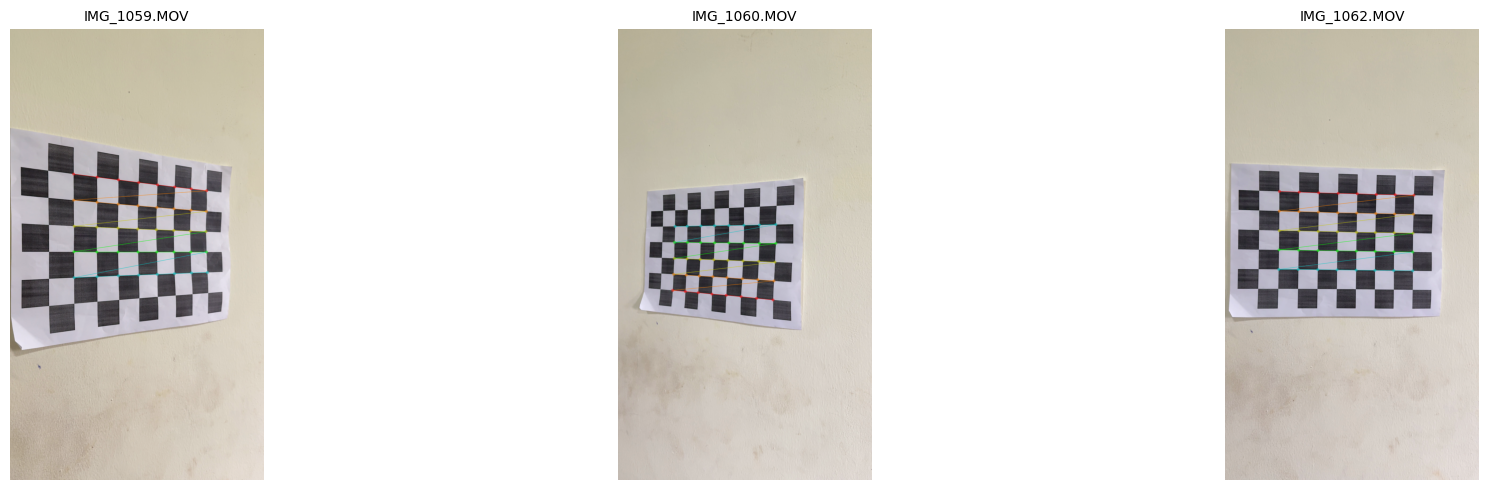

Saved: calibration_corners_detected.png


In [4]:
if sample_frames:
    n = len(sample_frames)
    fig, axes = plt.subplots(1, n, figsize=(7*n, 5))
    if n == 1:
        axes = [axes]
    for ax, (vp, vi) in zip(axes, sample_frames.items()):
        ax.imshow(cv2.cvtColor(vi, cv2.COLOR_BGR2RGB))
        ax.set_title(os.path.basename(vp), fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('calibration_corners_detected.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: calibration_corners_detected.png")
else:
    print("No corners detected in any video.")

## Step 5: Perform Camera Calibration

OpenCV solves for the camera matrix K and distortion coefficients.
**RMS reprojection error** below 1.0 is excellent.

In [5]:
assert len(objpoints) >= 3, f"Need >= 3 frames, got {len(objpoints)}"

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, image_size, None, None)

print("=" * 50)
print("CAMERA CALIBRATION RESULTS")
print("=" * 50)
print(f"RMS Reprojection Error: {ret:.4f} pixels")
print(f"  (< 1.0 excellent, < 2.0 acceptable)")
print(f"\nCamera Matrix K:")
print(f"  fx = {mtx[0,0]:.1f},  fy = {mtx[1,1]:.1f}")
print(f"  cx = {mtx[0,2]:.1f},  cy = {mtx[1,2]:.1f}")
print(f"  fx/fy = {mtx[0,0]/mtx[1,1]:.4f} (ideal: 1.0)")
print(f"\nDistortion: k1={dist[0,0]:.4f}, k2={dist[0,1]:.4f}")

CAMERA CALIBRATION RESULTS
RMS Reprojection Error: 0.8020 pixels
  (< 1.0 excellent, < 2.0 acceptable)

Camera Matrix K:
  fx = 1625.3,  fy = 1607.2
  cx = 656.3,  cy = 911.2
  fx/fy = 1.0112 (ideal: 1.0)

Distortion: k1=0.3906, k2=-3.3814


## Step 6: Per-Frame Error Analysis and Outlier Removal

Error: mean=0.1193, std=0.0429, max=0.2307
Removing 1 outlier(s)...


Filtered RMS: 0.7790 (was 0.8020)


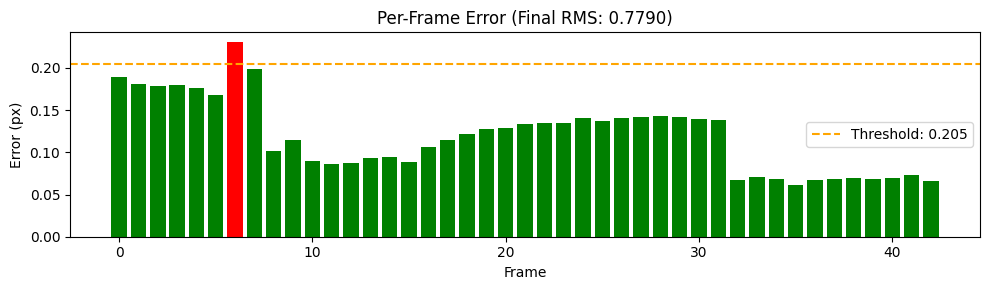

Saved: calibration_error_analysis.png


In [6]:
errors = []
for i in range(len(objpoints)):
    proj, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    errors.append(cv2.norm(imgpoints[i], proj, cv2.NORM_L2) / len(proj))

errors_arr = np.array(errors)
threshold = errors_arr.mean() + 2 * errors_arr.std()
good = errors_arr < threshold
n_bad = sum(~good)

print(f"Error: mean={errors_arr.mean():.4f}, std={errors_arr.std():.4f}, max={errors_arr.max():.4f}")

if n_bad > 0:
    print(f"Removing {n_bad} outlier(s)...")
    g_obj = [objpoints[i] for i in range(len(objpoints)) if good[i]]
    g_img = [imgpoints[i] for i in range(len(imgpoints)) if good[i]]
    ret2, mtx2, dist2, rv2, tv2 = cv2.calibrateCamera(g_obj, g_img, image_size, None, None)
    print(f"Filtered RMS: {ret2:.4f} (was {ret:.4f})")
    if ret2 < ret:
        ret, mtx, dist, rvecs, tvecs = ret2, mtx2, dist2, rv2, tv2
else:
    print("No outliers. Calibration is clean.")

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(range(len(errors)), errors, color=['green' if g else 'red' for g in good])
ax.axhline(threshold, color='orange', ls='--', label=f'Threshold: {threshold:.3f}')
ax.set_xlabel('Frame'); ax.set_ylabel('Error (px)')
ax.set_title(f'Per-Frame Error (Final RMS: {ret:.4f})')
ax.legend()
plt.tight_layout()
plt.savefig('calibration_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: calibration_error_analysis.png")

## Step 7: Save Calibration Data

In [7]:
np.savez("camera_calib.npz", mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs,
         image_size=np.array(image_size), rms_error=np.array([ret]))
print(f"Saved to camera_calib.npz")
print(f"Final RMS: {ret:.4f}, Frames: {len(rvecs)}, Size: {image_size}")

Saved to camera_calib.npz
Final RMS: 0.7790, Frames: 42, Size: (1080, 1920)


## Step 8: Verify - Undistort a Sample Frame

Straight edges should appear straight after undistortion.

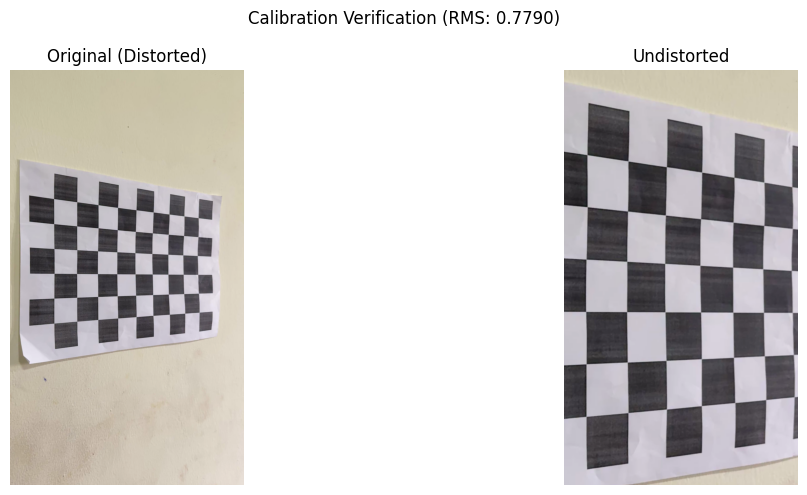

Saved: calibration_verification.png

Calibration complete. Proceed to Homography notebook.


In [8]:
cap = cv2.VideoCapture(video_files[0])
_, frame = cap.read()
cap.release()
frame = cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2))
h_f, w_f = frame.shape[:2]

newcam, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w_f, h_f), 0.5, (w_f, h_f))
undist = cv2.undistort(frame, mtx, dist, None, newcam)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original (Distorted)')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[1].set_title('Undistorted')
axes[1].axis('off')
plt.suptitle(f'Calibration Verification (RMS: {ret:.4f})')
plt.tight_layout()
plt.savefig('calibration_verification.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: calibration_verification.png")
print("\nCalibration complete. Proceed to Homography notebook.")